In [33]:
# Importing the needed libraries

import warnings
warnings.simplefilter('ignore')
import numpy 
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
data = pd.read_csv('pubmed.csv')

In [4]:
data.drop(['label_cir','label_nfl','label_hpc'], inplace=True, axis=1)
data=data[:200]

In [5]:
data.head(10)

,pmid,txt,label_hep
0,30558055,abo incompatible living donor liver transplant...,0
1,30558011,a human ciliopathy with polycystic ovarian syn...,0
2,30540737,vibrio cholerae no - o1 no - o139 bacteremia i...,0
3,30531115,ruptured ascending colonic varices in a patien...,0
4,30526986,a 44 - year - old woman with sudden breathless...,0
5,30507656,short article sequence variations of pkhd1 und...,0
6,30508897,primary biliary cirrhosis with refractory hypo...,0
7,30482030,auxiliary partial orthotopic liver transplanta...,0
8,30471833,intraoperative management of a patient with im...,0
9,30464164,successful treatment of repeated hematemesis s...,0


In [6]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
tokenized = data['txt'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation = True)))

- Padding :

After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. 
We want BERT/DistilBert to process the text all at once (as one batch) ==> pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [8]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [9]:
#the dimensions of the padded variables 

np.array(padded).shape

(200, 512)

- Masking :

because we can't pass padded variables to BERT models directly. We need to create another variable to 
tell it to ignore (mask) the padding we've added when it's processing its input (what attention_mask)

In [10]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(200, 512)

The model() function runs the sentences through DistilBERT and The results of the processing will be returned into "last_hidden_states"

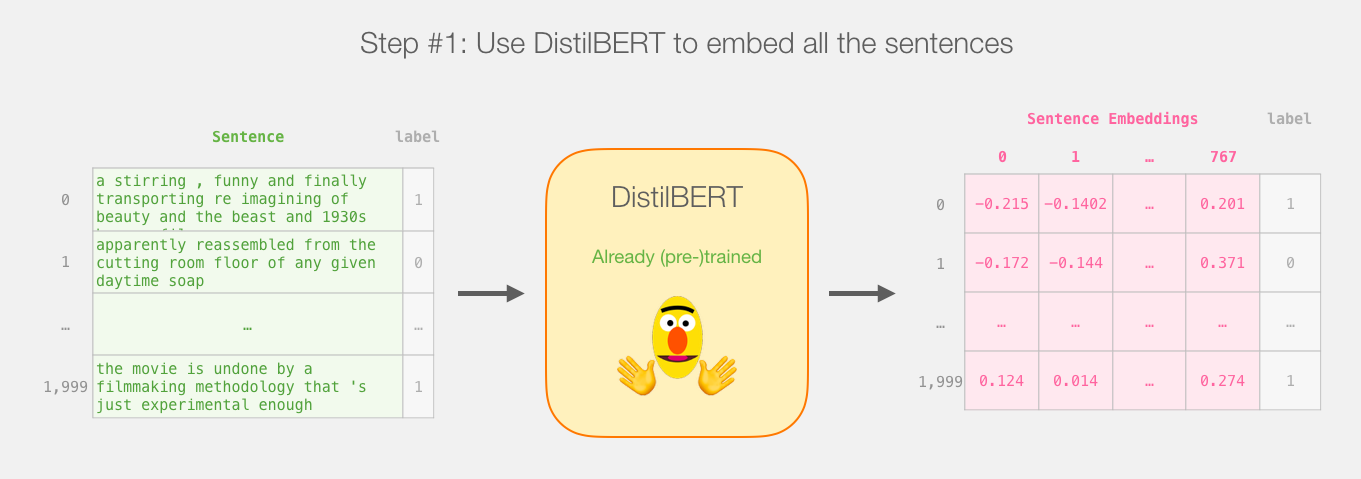

In [11]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

In [13]:
#my device crashed every time i run this code with full data, so i reduced its dimensions so i can run it

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

below is an illustration of the Last Hidden States of BERT/DistilBERT model where the right figure is after adding a special 
token "CLS" for classification task at the beginning of every sentence. 
The output corresponding to that token can be thought of as an embedding for the entire sentence. 

so, i guess you mean the output of the left figure ?!!
but how to get the size of "738"

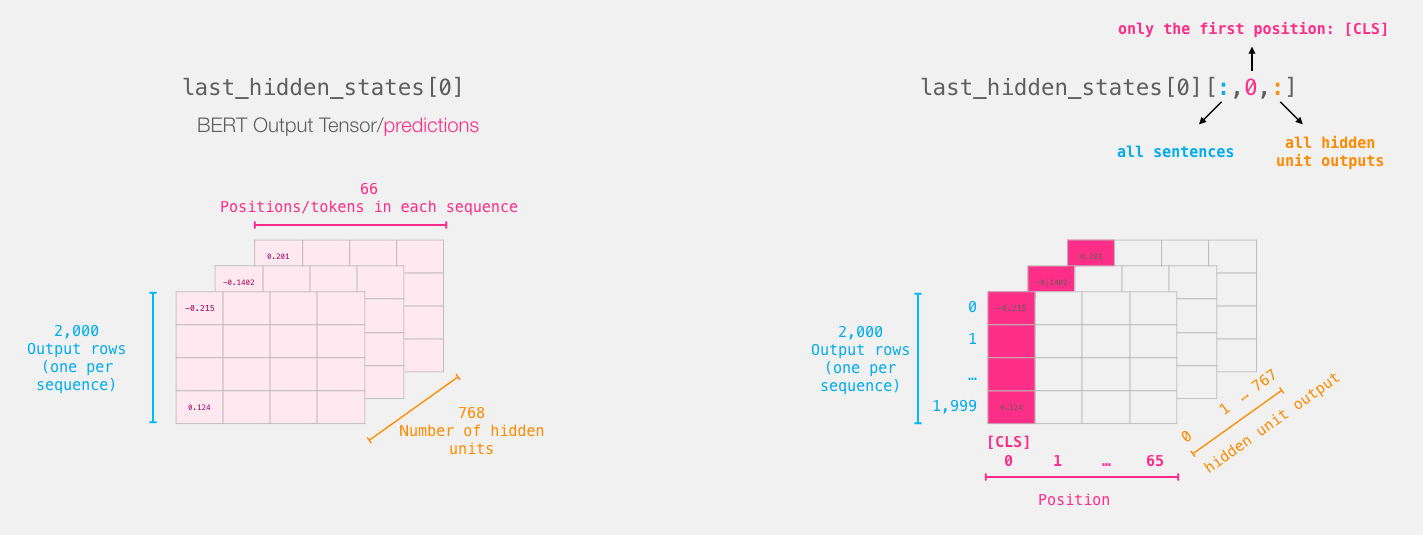

In [62]:
last_hidden_states[0]

tensor([[[-0.2956, -0.0992, -0.2288,  ..., -0.2952,  0.2933,  0.3875],
         [-0.1504,  0.3582, -0.3503,  ..., -0.0841,  0.8117,  0.2943],
         [-1.3197, -0.1894,  0.1812,  ..., -0.0909,  0.1714,  0.0736],
         ...,
         [ 0.0474, -0.1165,  0.2836,  ..., -0.0373, -0.1090, -0.1300],
         [ 0.1119, -0.1073,  0.3270,  ..., -0.0444, -0.0888, -0.1037],
         [ 0.1477, -0.1440,  0.1737,  ..., -0.0170, -0.1235, -0.1243]],

        [[-0.3269, -0.1935, -0.0069,  ..., -0.2375,  0.3665,  0.4159],
         [-0.5252,  0.4670, -0.3827,  ..., -0.3581,  0.1416,  0.2890],
         [-0.4943,  0.2957, -0.2047,  ..., -0.2106, -0.0854, -0.2089],
         ...,
         [ 0.0031,  0.2085,  0.4082,  ..., -0.0279, -0.2082, -0.1215],
         [ 0.0205,  0.0960,  0.5141,  ..., -0.0853, -0.2661, -0.1978],
         [-0.0115, -0.0359,  0.5496,  ..., -0.0795, -0.2033, -0.3501]],

        [[-0.2268, -0.1111, -0.3398,  ..., -0.3108,  0.4319,  0.3932],
         [ 0.6443, -1.0815,  0.3099,  ...,  0

In [63]:
lhs = last_hidden_states[0].numpy()

In [83]:
lhs.shape

(200, 512, 768)

In [79]:
data['txt'] = pd.DataFrame(dict(rows = list(lhs)))

In [81]:
data.head(20)

,pmid,txt,label_hep
0,30558055,"[[-0.29555374, -0.099218056, -0.22876085, -0.2...",0
1,30558011,"[[-0.3268623, -0.19347979, -0.006912589, -0.15...",0
2,30540737,"[[-0.22679791, -0.11108152, -0.33978486, -0.03...",0
3,30531115,"[[-0.36817712, -0.16568066, -0.13585395, -0.20...",0
4,30526986,"[[-0.5295584, -0.46468905, -0.26627576, -0.197...",0
5,30507656,"[[-0.45172855, -0.10710028, -0.41383368, -0.18...",0
6,30508897,"[[-0.31502864, -0.024332289, -0.08227223, -0.2...",0
7,30482030,"[[-0.38016924, -0.12637858, -0.113817796, -0.2...",0
8,30471833,"[[-0.47577283, -0.044647835, -0.13375677, -0.2...",0
9,30464164,"[[-0.45829207, -0.006762782, -0.16391644, -0.2...",0


In [84]:
import pickle 

pickle.dump(data, open('LHS.pkl','wb'))

In [85]:
model = pickle.load(open('LHS.pkl','rb'))

In [86]:
model

,pmid,txt,label_hep
0,30558055,"[[-0.29555374, -0.099218056, -0.22876085, -0.2...",0
1,30558011,"[[-0.3268623, -0.19347979, -0.006912589, -0.15...",0
2,30540737,"[[-0.22679791, -0.11108152, -0.33978486, -0.03...",0
3,30531115,"[[-0.36817712, -0.16568066, -0.13585395, -0.20...",0
4,30526986,"[[-0.5295584, -0.46468905, -0.26627576, -0.197...",0
...,...,...,...
195,28508167,"[[-0.24077347, -0.09595608, -0.24328028, -0.03...",0
196,28500122,"[[-0.3327879, -0.004856293, -0.32034922, -0.11...",0
197,28484121,"[[-0.41836554, -0.06971793, -0.10483992, -0.35...",0
198,28445299,"[[-0.305126, 0.008452704, 0.04265234, -0.11484...",1
